<p style="color:blue; font-size:300%; font-weight:bold; text-align: center;">Predict TripAdvisor Rating</p>

# **Импортируем модули**

In [17]:
import numpy as np
import pandas as pd 

# expanding output display
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import re
import csv
from datetime import datetime,timedelta

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MultiLabelBinarizer

!pip install -U textblob
# NLP sentiment analysis
from textblob import TextBlob

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Requirement already up-to-date: textblob in /home/iaan/anaconda3/lib/python3.8/site-packages (0.15.3)


In [18]:
RANDOM_SEED = 42

In [19]:
!pip freeze > requirements.txt

# **Загрузка данных**

In [20]:
df_train = pd.read_csv('data/main_task.csv')
df_test = pd.read_csv('data/kaggle_task.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [21]:
df_train['sample'] = 1
df_test['sample'] = 0

df_test['Rating'] = 0

df = df_test.append(df_train, sort=False).reset_index(drop=True)

# **Знакомство с данными**

In [22]:
# рассмотрим основную статистику
print('Shape:',df.shape)
print('\nПропуски:')
print(df.isnull().sum())

Shape: (50000, 11)

Пропуски:
Restaurant_id            0
City                     0
Cuisine Style        11590
Ranking                  0
Price Range          17361
Number of Reviews     3200
Reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
Rating                   0
dtype: int64


In [23]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
45738,id_8590,Paris,['French'],8592.0,$$ - $$$,6.0,"[['Amazing', 'the candy shop is a must stop to...",/Restaurant_Review-g187147-d10192577-Reviews-L...,d10192577,1,4.5
950,id_950,Hamburg,"['Turkish', 'Middle Eastern', 'Mediterranean',...",281.0,$,89.0,"[['very good', 'Authentic Turkish restaurant']...",/Restaurant_Review-g187331-d4226553-Reviews-OZ...,d4226553,0,0.0
27666,id_3477,Prague,"['European', 'Czech', 'Cafe', 'Eastern European']",3485.0,$$ - $$$,29.0,"[['Not welcoming', 'Quaint and intimate'], ['1...",/Restaurant_Review-g274707-d7124130-Reviews-Pa...,d7124130,1,3.0
13607,id_7323,Paris,['French'],7324.0,$$ - $$$,31.0,"[['delightful cafe', 'wrong place, right time!...",/Restaurant_Review-g187147-d3643761-Reviews-Au...,d3643761,1,3.5
26486,id_4943,Berlin,['European'],4945.0,$$ - $$$,24.0,[['I had a fantastic breakfast with friends o....,/Restaurant_Review-g187323-d4049335-Reviews-Ca...,d4049335,1,3.5


## *Работа с признаками*
# **1. ID_TA**

In [24]:
print(df['ID_TA'].value_counts())

d987900      2
d7337366     2
d4748208     2
d2360290     2
d11698990    2
            ..
d5890561     1
d9740197     1
d1464145     1
d7365820     1
d10031805    1
Name: ID_TA, Length: 49963, dtype: int64


In [25]:
# есть данные с одинаковыми TripAdvisor ID. Посчитаем сколько именно
print("\nDuplicate ID_TA:",(df['ID_TA'].value_counts()>1).sum())


Duplicate ID_TA: 37


**37 ресторанов с одиноковым ID.** Это в принципе немного,
но проверим ещё один уникальный параметр этих данных: URL_TA

In [26]:
ind = df['ID_TA'].value_counts()[:37].index

In [27]:
print('duplicates ID_TA URLs:',len(df.loc[df['ID_TA'].isin(ind),['URL_TA']]))
print('ID_TA URLs with dropped duplicates:',len(df.loc[df['ID_TA'].isin(ind),['URL_TA']].drop_duplicates()))

duplicates ID_TA URLs: 74
ID_TA URLs with dropped duplicates: 37


Получается, что это на самом деле одни и те же заведения.
Проверим все данные и сортируем по TripAdvisor ID

In [28]:
display(df.loc[df['ID_TA'].isin(ind)].sort_values(by='ID_TA').head(8))

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
48946,id_3242,Madrid,NaN,3244.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0
23980,id_3239,Madrid,NaN,3241.0,NaN,13.0,"[[], []]",/Restaurant_Review-g187514-d10047799-Reviews-E...,d10047799,1,5.0
28388,id_1229,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1231.0,$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,1,4.0
4534,id_4534,Madrid,"['Bar', 'European', 'Spanish', 'Delicatessen']",1253.0,$$$$,116.0,"[['Visited the rooftop bar', 'SIXTH FLOOR ROOF...",/Restaurant_Review-g187514-d1028622-Reviews-La...,d1028622,0,0.0
118,id_118,Warsaw,['Italian'],1801.0,$,3.0,"[[], []]",/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,0,0.0
36920,id_1800,Warsaw,['Italian'],1801.0,$,3.0,"[[], []]",/Restaurant_Review-g274856-d10316215-Reviews-B...,d10316215,1,3.5
23576,id_1277,Madrid,"['Asian', 'Thai', 'Vegetarian Friendly']",1279.0,$$ - $$$,70.0,"[['Delicious soup', 'My weekly treat'], ['03/1...",/Restaurant_Review-g187514-d10440367-Reviews-B...,d10440367,1,4.0
8551,id_8551,Madrid,"['Asian', 'Thai', 'Vegetarian Friendly']",1206.0,$$ - $$$,70.0,"[['Delicious soup', 'My weekly treat'], ['03/1...",/Restaurant_Review-g187514-d10440367-Reviews-B...,d10440367,0,0.0


Отличаются только параметры Restaurant_id и Ranking. В Ranking при этом разница не существена.
Не до конца понятно с чем это может быть связано, и как мы можем улучшить эти данные, так что пока оставим как есть.
Но запомним, что такое наблюдение имеется

In [29]:
# напослдеок вынесем id как отдельный числовой параметр:
df['ID short'] = df['ID_TA'].apply(lambda x: int(x[1:]))

# **2. URL_TA**

In [30]:
# рассмотрим пример того, как выглядит этот параметр
df['URL_TA'][1]

'/Restaurant_Review-g189934-d6674944-Reviews-Ravintola_Kolmon3n-Helsinki_Uusimaa.html'

в ссылке можно заметить много полезной информации: Название заведения, Город, Область, опять же-таки ID

In [31]:
print('URL_TA Duplicates:',(df['URL_TA'].value_counts()>1).sum())
# точно такая же ситуация, что и с ID_TA

URL_TA Duplicates: 37


In [32]:
# вынесем название заведения отдельным параметром на всякий случай
name_pattern = re.compile(r"Reviews-([\w\s]+)")
localization_pattern = re.compile
df['Restaurant name'] = df['URL_TA'].map(lambda x: name_pattern.search(x).group(1).replace("_"," "))

# **3. Restaurant_id**

In [33]:
# подсчитаем данные
df['Restaurant_id'].value_counts()

id_436      19
id_633      19
id_871      19
id_227      19
id_71       18
            ..
id_14232     1
id_15308     1
id_10428     1
id_12858     1
id_14655     1
Name: Restaurant_id, Length: 13094, dtype: int64

Очень много повторений. Вручную сверим параметры по Restaurant_id с самым большим числом повторений

In [34]:
r_id = df['Restaurant_id'].value_counts().index[0]

In [35]:
df_ex = df.loc[df['Restaurant_id'] == r_id]
display(df_ex)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,ID short,Restaurant name
436,id_436,Lisbon,"['European', 'Portuguese']",2904.0,NaN,2.0,"[[], []]",/Restaurant_Review-g189158-d5003144-Reviews-Gu...,d5003144,0,0.0,5003144,Gut Your Flavour
12955,id_436,Barcelona,"['Seafood', 'Mediterranean', 'Spanish', 'Glute...",437.0,$$ - $$$,546.0,"[['Fresh Fish', 'Perfect concept'], ['01/03/20...",/Restaurant_Review-g187497-d1592613-Reviews-La...,d1592613,1,4.5,1592613,La Paradeta Sants
14674,id_436,Copenhagen,"['European', 'Spanish', 'Mediterranean', 'Vege...",437.0,$$ - $$$,89.0,"[['Lovely restaurant', 'Great atmosphere and g...",/Restaurant_Review-g189541-d8738362-Reviews-To...,d8738362,1,4.0,8738362,Toro
16118,id_436,Oporto,"['European', 'Portuguese', 'Soups', 'Cafe', 'V...",437.0,$,71.0,"[['Super nice healthy and good', 'Great lunch ...",/Restaurant_Review-g189180-d9463122-Reviews-Ca...,d9463122,1,4.5,9463122,Carmelita Bistro
16215,id_436,Budapest,"['American', 'Vegetarian Friendly', 'Vegan Opt...",437.0,$,68.0,"[['Excellent', 'Best burger ever!'], ['12/05/2...",/Restaurant_Review-g274887-d10438365-Reviews-B...,d10438365,1,4.5,10438365,Beefstro Burger
17377,id_436,Luxembourg,['Asian'],437.0,NaN,2.0,"[['ZEN'], ['06/11/2016']]",/Restaurant_Review-g190356-d743888-Reviews-Zen...,d743888,1,4.5,743888,Zen
18168,id_436,Oslo,"['European', 'Scandinavian']",437.0,$$$$,51.0,"[['Stunning views over Oslo', 'Brilliant break...",/Restaurant_Review-g190479-d2036436-Reviews-Re...,d2036436,1,4.0,2036436,Restaurant Holmenkollen Park Hotel Rica Kongev...
18497,id_436,Milan,"['Italian', 'Pizza', 'Mediterranean', 'Vegetar...",437.0,$$ - $$$,855.0,"[['Nice Napoli style pizza place', 'Great Neap...",/Restaurant_Review-g187849-d1553645-Reviews-Il...,d1553645,1,4.0,1553645,Il Tegamino
22554,id_436,Ljubljana,NaN,437.0,NaN,14.0,"[['Terrible staff and service', 'Disrespectful...",/Restaurant_Review-g274873-d12607480-Reviews-C...,d12607480,1,3.0,12607480,Centralna Postaja
23313,id_436,Krakow,['Vegetarian Friendly'],437.0,$$ - $$$,18.0,"[['Great find, 100% recommend', 'Amazing brunc...",/Restaurant_Review-g274772-d12404722-Reviews-R...,d12404722,1,4.5,12404722,Ranny Ptaszek


**Что у нас есть?**<br>
<br>
Города все разные<br>
Кухни тоже<br> 
В глаза бросается связь между **Restaurant_id** и **Ranking**, отличается только в Лисабоне (значительно) и Мюнхене (не значительно)<br>
Причем, числовая составляющая id, очень близка к Рангу. Видимо id генерируется на основе Ранга. Обязательно проверить корреляцию!!!<br>
Цены - разные, присутствуют пропуски<br> 
Названия заведений - разные.

In [36]:
rest_id_ind = (df['Restaurant_id'].value_counts()>1).index
df['Not unique Rid'] = df['Restaurant_id'].apply(lambda x: int(x in rest_id_ind))

In [37]:
# вынесем кол-во повторений
rest_id = df['Restaurant_id'].value_counts().to_dict()
df['Restaurants same Rid'] = df['Restaurant_id'].map(rest_id)

In [38]:
#также вынесем числовую составляющую Restaurant_id отдельным параметром
df['Rid short'] = df['Restaurant_id'].apply(lambda x: int(x[3:]))

In [39]:
# теперь можно посчитать корреляцию между Ranking и Restaurant_id
display(np.corrcoef(df['Rid short'],df['Ranking']))

array([[1.        , 0.82508989],
       [0.82508989, 1.        ]])

Как мы и ожидали, взаимосвязь **подтвердилась**

<AxesSubplot:xlabel='Ranking', ylabel='Rid short'>

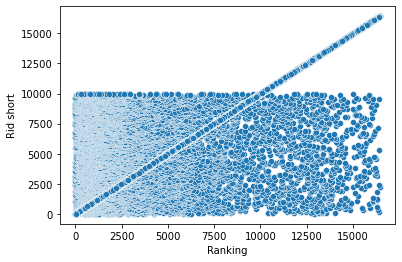

In [40]:
a4_dims = (11.7, 8.27)
sns.scatterplot(x=df['Ranking'],y=df['Rid short'])

Вырисовывается интересная картина. Есть данные с почти нормальным распределением, которые не выходят выше показателя Restaurant_id 10000,<br>
А так же широкий пласт заведений с идентичными показателями id и ранга (это теже заведения, пример которых я выводил выше)

# **4. Number Of Reviews**

In [41]:
# вынесем пропуски в данных отдельным параметром
df['NoR NAN'] = pd.isna(df['Number of Reviews']).astype('uint8')

In [42]:
# глянем в статистику
df['Number of Reviews'].describe()

count    46800.000000
mean       124.471197
std        294.114345
min          2.000000
25%          9.000000
50%         33.000000
75%        115.000000
max       9660.000000
Name: Number of Reviews, dtype: float64

Медиана и средняя сильно разняться, это значит, что в параметре много выбросов. для более детальной картины можно глянуть статистику по городам.

<AxesSubplot:xlabel='City'>

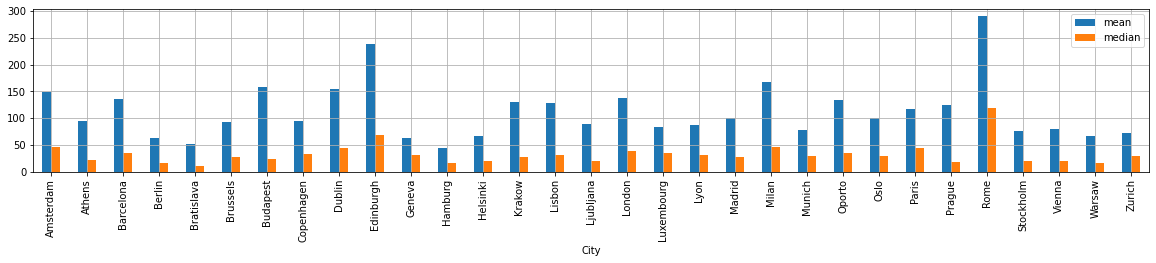

In [43]:
df.groupby(['City'])['Number of Reviews'].agg(['mean','median']).plot(kind='bar',figsize=[20,3],grid=True)

In [44]:
# будем заполнять пропуски медианой по городам, она в данном случае более объективно представляет информацию

gb_city = round(df.groupby(['City'])['Number of Reviews'].median()).to_dict() # создаем словарь
df['Number of Reviews'].fillna(df['City'].map(gb_city),inplace=True) # заменяем пропуски, применяя словарь

# **5. Cuisine Style**

кухни представлены в виде строки, а не листа, как это может показаться сначала


In [45]:
# ознакомимся с данными
df['Cuisine Style'].sample(10)

16769             ['Mediterranean', 'European', 'Spanish']
22711                                           ['Kosher']
32898    ['Indian', 'Asian', 'Balti', 'Eastern European...
33508    ['Italian', 'Pizza', 'European', 'Central Euro...
36609                                                  NaN
4501                                                   NaN
20075    ['Italian', 'Pizza', 'European', 'Vegetarian F...
12730                    ['Indian', 'Vegetarian Friendly']
21653                                                  NaN
41649                             ['Seafood', 'Fast Food']
Name: Cuisine Style, dtype: object

In [46]:
# сосчитаем пропуски
df['Cuisine Style'].isna().sum()

11590

In [47]:
# функция приводит наши данные к правильному формату

def getCuisines(series):
    pattern = re.compile(r"'([a-z\s]+)'",flags=re.I)
    matches = pattern.findall(str(series))
    return matches

In [48]:
df['Cuisine Style'] = df['Cuisine Style'].apply(getCuisines)

In [49]:
# вынесем наличие пустых списков
df['Cuisine NAN'] = (df['Cuisine Style'].str.len()==0).astype('uint8')

In [50]:
# перед тем как начать заполнять пропуски, выведем отдельным параметром кол-во представленых в ресторане кухонь
df['Cuisine variety'] = df['Cuisine Style'].apply(lambda x: len(x))

In [51]:
# попробуем заполнить пропуски двумя самыми часто встречающимися кухнями по городу
city_cuisine_modes = list(df.groupby(['City'])['Cuisine Style'].apply(
    lambda x: x.explode().value_counts()[0:2]).index)

# превращаем в словарь
l = []
[[l.append(y) for y in x] for x in city_cuisine_modes]
k = l[::4] # key
v = l[1::2] # value
v = [v[x:x+2] for x in range(0,len(v),2)]
city_cuisines = dict(zip(k,v))
display(city_cuisines)

{'Amsterdam': ['European', 'Vegetarian Friendly'],
 'Athens': ['Greek', 'Mediterranean'],
 'Barcelona': ['Spanish', 'Mediterranean'],
 'Berlin': ['Vegetarian Friendly', 'European'],
 'Bratislava': ['European', 'Central European'],
 'Brussels': ['European', 'Belgian'],
 'Budapest': ['European', 'Hungarian'],
 'Copenhagen': ['European', 'Vegetarian Friendly'],
 'Dublin': ['Vegetarian Friendly', 'European'],
 'Edinburgh': ['Vegetarian Friendly', 'British'],
 'Geneva': ['European', 'Vegetarian Friendly'],
 'Hamburg': ['Vegetarian Friendly', 'European'],
 'Helsinki': ['European', 'Vegetarian Friendly'],
 'Krakow': ['European', 'Polish'],
 'Lisbon': ['European', 'Portuguese'],
 'Ljubljana': ['European', 'Slovenian'],
 'London': ['Vegetarian Friendly', 'British'],
 'Luxembourg': ['European', 'Vegetarian Friendly'],
 'Lyon': ['French', 'European'],
 'Madrid': ['Spanish', 'Mediterranean'],
 'Milan': ['Italian', 'Vegetarian Friendly'],
 'Munich': ['Vegetarian Friendly', 'European'],
 'Oporto': [

In [52]:
# теперь заменим пропуски наиболее часто встречающимися кухнями по городу
df['Cuisine Style'] = df['Cuisine Style'].fillna(df['City'].map(city_cuisines))

In [53]:
# проверим кол-во уникальных кухонь напоследок
df['Cuisine Style'].explode().nunique()

124

# **6. Reviews**

In [54]:
# глянем как выглядит пример отзыва
print(df['Reviews'][1])
# и тип данных
print(type(df.Reviews[1]))

[['Very good reviews!', 'Fine dining in Hakaniemi'], ['12/05/2017', '10/29/2017']]
<class 'str'>


Опять же таки, надо перевести отзывы в нужный формат, что с ними можно было работать 

In [55]:
# но сначала проверим пропуски
df['Reviews'].isna().sum()

2

In [56]:
# заменим их строкой с якобы пустыми отзывами
df['Reviews'].fillna('[[], []]', inplace=True)

In [57]:
# теперь глянем сколько у нас пустых отзывов
len(df.loc[df['Reviews'] == '[[], []]','Reviews'])

8114

In [58]:
# вынесем пустые списки отдельным параметром
df['Reviews NAN'] = (df['Reviews'].isin(['[[], []]'])).astype('uint8')

In [59]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,ID short,Restaurant name,Not unique Rid,Restaurants same Rid,Rid short,NoR NAN,Cuisine NAN,Cuisine variety,Reviews NAN
37813,id_1705,London,"[Italian, Fast Food, Mediterranean, European, ...",1708.0,$$ - $$$,205.0,[['This small restaurant is a little hidden g....,/Restaurant_Review-g186338-d10206729-Reviews-M...,d10206729,1,4.5,10206729,Mister Lasagna,1,10,1705,0,0,6,0
20459,id_3851,Barcelona,"[Mediterranean, European, Spanish, Gluten Free...",3852.0,$$ - $$$,229.0,"[['Caters to Large Groups', 'Enjoyable'], ['10...",/Restaurant_Review-g187497-d3138524-Reviews-Cu...,d3138524,1,3.5,3138524,Cullera de Boix Boqueria,1,3,3851,0,0,4,0
22428,id_7356,Paris,[],7357.0,NaN,2.0,"[['Best Greek...in the world'], ['09/23/2017']]",/Restaurant_Review-g187147-d12929620-Reviews-B...,d12929620,1,5.0,12929620,Bistro Mavrommatis Passy,1,2,7356,0,1,0,0
41367,id_2816,Milan,[],2818.0,NaN,23.0,"[['Hidden Gem'], ['04/30/2017']]",/Restaurant_Review-g187849-d10257861-Reviews-D...,d10257861,1,4.0,10257861,D Karbon Limon 2,1,7,2816,0,1,0,0
37163,id_20,Paris,"[French, European]",21.0,$$$$,295.0,"[['Haute cuisine without the fuss', 'Wonderful...",/Restaurant_Review-g187147-d8074327-Reviews-Re...,d8074327,1,4.5,8074327,Restaurant L INITIAL,1,12,20,0,0,2,0


In [60]:
# выделим даты отдельно

def review_to_date(review):
    pattern = re.compile('\'\d+\/\d+\/\d+\'?')
    dates = pattern.findall(review)
    if len(dates) >= 1:
        datetime_list = []
        for date in dates:
            date = date.strip("'")
            dt = datetime.strptime(date, '%m/%d/%Y')
            datetime_list.append(dt)
        return datetime_list
    else:
        return dates
    
df['Reviews'] = df['Reviews'].astype(str)

In [61]:
df['Reviews dates'] = df['Reviews'].apply(review_to_date)

добавим отдельный признак: **кол-во дней между отзывами**


In [62]:
# функция, высчитывающая период между 2-мя последними отзывами

def review_dates_gap(dates):
    if len(dates) == 2:
        return int(abs((dates[0] - dates[1]).days))
    else:
        return 0

In [63]:
df['Reviews gap'] = df['Reviews dates'].apply(review_dates_gap)

теперь попробуем разделить разделить отзывы

In [64]:
df['Reviews'] = df['Reviews'].str.replace(r'\'\d+\/\d+\/\d+\'?','')\
.str.replace(r"\[, \]\]","").str.replace(r"\[\[","").str.replace(r"\], ","").str.replace(r"\[\]\]","")

In [65]:
df['Reviews'] = df['Reviews'].str.replace(r"[\'|\"], [\'|\"]","|||") 
# я заменил запятую между квадратными скобками нетипичным знаком, чтобы не было вероятности, 
# что при разделении строки в список, этот знак повторится

In [66]:
# превращаем строку в лист с двумя элементами (там где можно)
df['Reviews'] = df['Reviews'].apply(lambda x: x.strip("'").split("|||"))

In [67]:
# подсчитаем наш результат
display(df['Reviews'].apply(lambda x: len(x)).value_counts())
print('\n')
# и выведем на экран наши труды
display(df['Reviews'].sample(20))

2    36204
1    13796
Name: Reviews, dtype: int64

8561          [Bloody brilliant festive burger, Cheap pub]
10529                                   [Lunch time treat]
40673              [friendly and relaxed food, Very good.]
44838    [local favorite, very warm service with gre......
41452    [Very chill cocktail experience, Another great...
42821    [Mediamanga is the whole package, Delicious tr...
30472    [Italian-finnish fusion, Interesting, charming...
34438    [Quality fish, chill vibe, lovely staff, Charm...
39598    [It was recommended to me by a cousin and I......
38826    [Our favorite spot for affordable Japanese...,...
46889                           [Cozy pub, Irish in heart]
44930                                                   []
5497                    [Deliciously Fresh and Flavorful!]
18801                                                   []
19385                                                   []
9166                                                    []
5062     [Little gem, Off the beaten track, Perfect pla.

По-моему выглядит неплохо :) <br>Теперь подсчитаем сентимент для каждого отзыва.<br>
Я воспользуюсь сторонним модулем **TextBlob** для выделения полярности сентимента

In [68]:
# функция возвращает полярность сентимента для каждого отзыва
def getPolarity(reviews):
    return [float(TextBlob(review).sentiment.polarity) for review in reviews]

In [69]:
df['Reviews sentiment'] = df['Reviews'].apply(getPolarity)

Выведем дополнительные параметры из получившегося выше

In [70]:
# среднее
from statistics import mean
df['Reviews sentiment mean'] = df['Reviews sentiment'].map(lambda x: mean(x))

In [71]:
# вынесем каждый отзыв отдельным признаком
df['Review1 sentiment'] = df['Reviews sentiment'].apply(lambda x: x[0])

In [72]:
# второй отзыв
len_reviews_ind = df.loc[df['Reviews sentiment'].apply(lambda x: len(x)==2)]['Reviews sentiment'].index
df['Review2 sentiment'] = df.loc[df['Reviews sentiment'].index.isin(len_reviews_ind)]['Reviews sentiment'].apply(lambda x: x[1])

In [73]:
# заполним пропуски параметра со вторым отзывом нулями. Либо, тоже вариант, можно продублировать 1ый сентимент
df['Review2 sentiment'].fillna(0,inplace=True)

Можно ещё вынести отдельным параметром длину отзыва, что бы обособить вариатнты без отзывов, <br>
но имеющие 0 (нейтральный) в столбцах сентимента отзывов.

In [74]:
# функция возвращает длину отзывов

def getReviewLength(reviews):
    
    l = [len(review.split(" ")) if len(review)>=1 else 0 for review in reviews]
    if len(l) == 1: # добавим второй 0, что бы дальше было легче манипулировать
        l.append(0)
    return l

In [75]:
df['Review1 len'] = df['Reviews'].apply(getReviewLength).apply(lambda x: x[0])
df['Review2 len'] = df['Reviews'].apply(getReviewLength).apply(lambda x: x[1])

# **7. Price Range**

In [76]:
# ознокомимся с данными
df['Price Range'].sample(10)

32019           $
1546          NaN
24997         NaN
15243    $$ - $$$
22599    $$ - $$$
38485         NaN
25495           $
41681    $$ - $$$
12165         NaN
17320        $$$$
Name: Price Range, dtype: object

In [77]:
# заменим знаки на цифры
df['Price Range'] = df['Price Range'].replace({'$':1,'$$ - $$$':2,'$$$$':3})

In [78]:
# посмотрим статисику
display(df['Price Range'].describe())
print('')
# и кол-во пропусков
display(df['Price Range'].isna().sum())

count    32639.000000
mean         1.815129
std          0.509800
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: Price Range, dtype: float64

17361

<AxesSubplot:xlabel='City'>

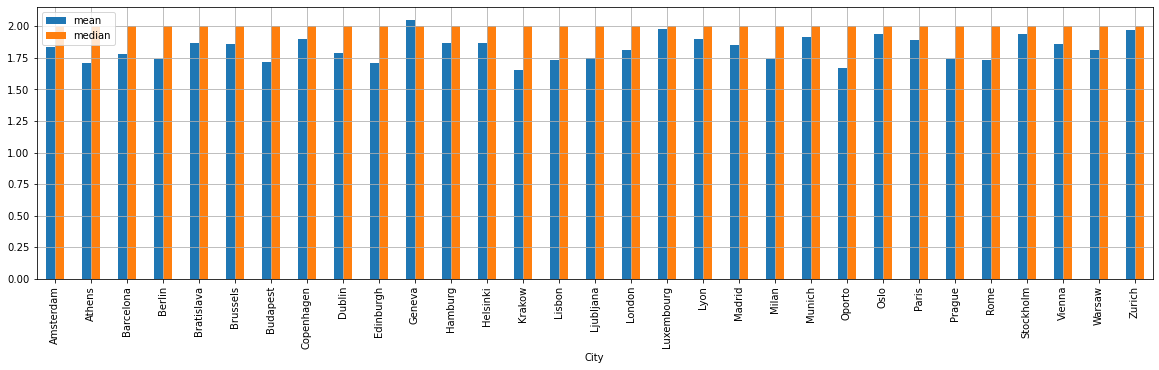

In [79]:
# глянем распределение по городам

gb_city = df.groupby(['City'])['Price Range'].agg(['mean','median'])
gb_city.plot(kind='bar',figsize=[20,5],grid=True)

Судя по результату, в Женеве больше всего ресторанов из высшей ценовой категории.<br>В общем, можем сделать вывод, что данные не пострадают, если заполнить пропуски модой (2)

In [80]:
# перед заполнением пропусков, пометим их как отдельный параметр
df['Price NAN'] = pd.isna(df['Number of Reviews']).astype('uint8')

In [81]:
# заполняем модой
df['Price Range'].fillna(2,inplace=True)

In [82]:
# глянем промежуточную статистику по данным
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Restaurant_id           50000 non-null  object 
 1   City                    50000 non-null  object 
 2   Cuisine Style           50000 non-null  object 
 3   Ranking                 50000 non-null  float64
 4   Price Range             50000 non-null  float64
 5   Number of Reviews       50000 non-null  float64
 6   Reviews                 50000 non-null  object 
 7   URL_TA                  50000 non-null  object 
 8   ID_TA                   50000 non-null  object 
 9   sample                  50000 non-null  int64  
 10  Rating                  50000 non-null  float64
 11  ID short                50000 non-null  int64  
 12  Restaurant name         50000 non-null  object 
 13  Not unique Rid          50000 non-null  int64  
 14  Restaurants same Rid    50000 non-null

Это был последний параметр с пропусками!<br>
Но мы ещё не выжали максимум из других параметров, так что продолжаем 

# **8. City**

In [83]:
# Знакомимся с данными
display(df['City'].describe())
print('')
display(df['City'].value_counts())

count      50000
unique        31
top       London
freq        7193
Name: City, dtype: object

London        7193
Paris         6108
Madrid        3813
Barcelona     3395
Berlin        2705
Milan         2694
Rome          2589
Prague        1816
Lisbon        1647
Vienna        1443
Amsterdam     1372
Brussels      1314
Hamburg       1186
Munich        1145
Lyon          1126
Stockholm     1033
Budapest      1021
Warsaw         925
Dublin         836
Copenhagen     819
Athens         776
Edinburgh      745
Zurich         685
Oporto         642
Geneva         590
Krakow         554
Oslo           488
Helsinki       475
Bratislava     380
Luxembourg     263
Ljubljana      222
Name: City, dtype: int64

Немножко взбогатим наши данные. На основе этого признака добавим:
* **Страна**
* **ВВП**
* **Население города**
* **Население страны**
* **Плотность города**
* **Столица ли**
* **Средний доход в городе**
* **Кол-во ресторанов со звёздами Michelin**
* **Кол-во ресторанов в базе данных Tripadvisor на 2021**
* **Кол-во заведений по городу в датасете**
* **Кол-во жителей на одно заведение**
<br>
<br>
Я хотел ещё добавить статистику по кол-ву туристов в год, но не смог найти точной информацию по всем городам<br>
Ещё можно заморочиться, и найти данные с названиями мишленовских ресторанов и сравнить с нашими названиями.<br>Но на это нужно потратить слишком много времени и работы, а не понятно, будет ли с этого толк.<br>Оставим эту затею на будущее

In [84]:
country = {'Paris':'France', 'Helsinki':'Finland', 'Edinburgh':'GB', 'London':'GB', 'Bratislava':'Slovakia', 'Lisbon':'Portugal',
       'Budapest':'Hungary', 'Stockholm':'Sweden', 'Rome':'Italy', 'Milan':'Italy', 'Munich':'Germany', 'Hamburg':'Germany',
       'Prague':'Czechia', 'Vienna':'Austria', 'Dublin':'Ireland', 'Barcelona':'Spain', 'Brussels':'Belgium', 'Madrid':'Spain',
       'Oslo':'Norway', 'Amsterdam':'Netherlands', 'Berlin':'Germany', 'Lyon':'France', 'Athens':'Greece', 'Warsaw':'Poland',
       'Oporto':'Portugal', 'Krakow':'Poland', 'Copenhagen':'Denmark', 'Luxembourg':'Luxembourg', 'Zurich':'Switzerland', 'Geneva':'Switzerland',
       'Ljubljana':'Slovenia'}

In [85]:
country_gdp = {'France':2.716, 'Finland':0.2693, 'GB':2.829, 'Slovakia':0.1051, 'Portugal':0.2388, 'Hungary':0.1635, 'Sweden': 0.5309,
              'Italy':2.004, 'Germany':3.861, 'Czechia':0.2507, 'Austria':0.4451, 'Ireland':0.3887, 'Spain':1.393, 'Belgium': 0.5331,
               'Norway':0.4033, 'Netherlands':0.9071, 'Greece':0.2099, 'Poland':0.5959, 'Denmark':0.3501, 'Luxembourg': 0.0711, 
               'Switzerland':0.7031, 'Slovenia': 0.05417}

In [86]:
city_pop = {'Paris':2.196, 'Helsinki':0.632, 'Edinburgh':0.555, 'London':8.982, 'Bratislava':0.424, 'Lisbon':0.505,
       'Budapest':1.756, 'Stockholm':0.975, 'Rome':2.873, 'Milan':1.352, 'Munich':1.472, 'Hamburg':1.841,
       'Prague':1.309, 'Vienna':1.897, 'Dublin':0.544, 'Barcelona':1.62, 'Brussels':1.209, 'Madrid':3.223,
       'Oslo':0.681, 'Amsterdam':0.822, 'Berlin':3.769, 'Lyon':0.513, 'Athens':0.664, 'Warsaw':1.765,
       'Oporto':0.214, 'Krakow':0.779, 'Copenhagen':0.602, 'Luxembourg':0.614, 'Zurich':0.428, 'Geneva':0.499,
       'Ljubljana':0.280}

In [87]:
coutry_pop = {'France':67.06, 'Finland':5.518, 'GB':66.65, 'Slovakia':5.45, 'Portugal':10.28, 'Hungary':9.773, 'Sweden': 10.23,
              'Italy':60.36, 'Germany':83.02, 'Czechia':10.65, 'Austria':8.859, 'Ireland':4.904, 'Spain':46.94, 'Belgium': 11.46,
               'Norway':5.328, 'Netherlands':17.28, 'Greece':10.72, 'Poland':37.97, 'Denmark':5.806, 'Luxembourg':0.614, 
               'Switzerland':8.545, 'Slovenia':2.081}

In [88]:
city_density = {'Paris':20.909, 'Helsinki':2.986, 'Edinburgh':1.830, 'London':5.701, 'Bratislava':1.169, 'Lisbon':6.446,
       'Budapest':3.337, 'Stockholm':5.012, 'Rome':3.389, 'Milan':7.519, 'Munich':4.736, 'Hamburg':2.464,
       'Prague':4.600, 'Vienna':4.556, 'Dublin':4.811, 'Barcelona':15.991, 'Brussels':7.465, 'Madrid':5.390,
       'Oslo':6.900, 'Amsterdam':5.135, 'Berlin':4.090, 'Lyon':10.460, 'Athens':19.135, 'Warsaw':3.372,
       'Oporto':5.143, 'Krakow':3.421, 'Copenhagen':4.417, 'Luxembourg':0.238, 'Zurich':4.700, 'Geneva':13.000,
       'Ljubljana':1.712}

In [89]:
capitals = ['Paris', 'Helsinki', 'London', 'Bratislava', 'Lisbon', 'Budapest', 'Stockholm', 'Rome', 
            'Prague', 'Vienna', 'Dublin', 'Brussels', 'Madrid', 'Oslo', 'Amsterdam', 'Berlin', 'Athens', 
            'Warsaw', 'Oporto', 'Copenhagen', 'Luxembourg', 'Ljubljana']

In [90]:
city_income = {'Amsterdam': 3.7,'Athens': 0.9, 'Barcelona': 1.9, 'Berlin': 2.7, 'Bratislava': 0.9, 'Brussels': 2,
               'Budapest': 0.6, 'Copenhagen': 4.1, 'Dublin': 2.1, 'Edinburgh': 2, 'Geneva': 5.4, 'Hamburg': 3.8,
               'Helsinki': 2.5, 'Krakow': 1.1, 'Lisbon': 0.9, 'Ljubljana': 1.2, 'London': 2.5, 'Luxembourg': 6.2,
               'Lyon': 1.6, 'Madrid': 3, 'Milan': 1.9, 'Munich': 3.9, 'Oporto': 1.2, 'Oslo': 1.7, 'Paris': 3.8,
               'Prague': 1.1, 'Rome': 1.8, 'Stockholm': 4.1, 'Vienna': 3, 'Warsaw': 1.2, 'Zurich': 7.0}

In [91]:
# [3*,2*,1*,sum] 
michelin_stars_by_city = {'Amsterdam':[0,3,17,20], 'Athens':[0,1,3,4], 'Barcelona':[2,6,14,22], 'Berlin':[1,5,18,24], 
                          'Bratislava':[0,0,0,0],'Brussels':[0,1,4,5], 'Budapest':[0,1,5,6], 'Copenhagen':[1,5,7,13], 
                          'Dublin':[0,2,1,3], 'Edinburgh':[0,0,2,2], 'Geneva':[0,1,9,10], 'Hamburg':[1,2,6,9], 'Helsinki':[0,0,6,6],
                          'Krakow':[0,0,1,1], 'Lisbon':[0,2,10,12], 'Ljubljana':[0,0,1,1], 'London':[5,8,53,66], 
                          'Luxembourg':[0,1,8,9], 'Lyon':[0,3,14,17], 'Madrid':[1,4,14,19], 'Milan':[1,2,12,15], 'Munich':[1,3,7,11], 
                          'Oporto':[0,2,3,5], 'Oslo':[0,0,1,1], 'Paris':[10,12,92,114], 'Prague':[0,0,2,2], 'Rome':[1,1,17,19], 
                          'Stockholm':[1,3,5,9], 'Vienna':[1,4,7,12], 'Warsaw':[0,0,0,0], 'Zurich':[0,4,14,18]}

In [92]:
TA_rest_by_city = {'Amsterdam':4034,'Athens':2580, 'Barcelona':9601, 'Berlin':6246, 'Bratislava':1276, 'Brussels':3641,
               'Budapest':3085, 'Copenhagen':2354, 'Dublin':2355, 'Edinburgh':1917, 'Geneva':1606, 'Hamburg':3265,
               'Helsinki':1550, 'Krakow':1783, 'Lisbon':4954, 'Ljubljana':602, 'London':20078, 'Luxembourg':743,
               'Lyon':2818, 'Madrid':11596, 'Milan':7475, 'Munich':3176, 'Oporto':1995, 'Oslo':1293, 'Paris':17258,
               'Prague':5413, 'Rome':11067, 'Stockholm':3036, 'Vienna':4151, 'Warsaw':3280, 'Zurich':1866}

In [93]:
rest_amount_by_city = df['City'].value_counts().to_dict()

In [94]:
# функция проверяет, является ли столицей город
def isCapital(city):
    if city in capitals:
        return 1
    else:
        return 0

In [95]:
# теперь создадим новые параметры на основе наших словарей

df['Country'] = df['City'].map(country)
df['GDP'] = df['Country'].map(country_gdp)
df['Country pop'] = df['Country'].map(coutry_pop)
df['City pop'] = df['City'].map(city_pop)
df['City density'] = df['City'].map(city_density)
df['isCapital'] = df['City'].apply(isCapital)
df['City income'] = df['City'].map(city_income)
df['Michelin-starred'] = df['City'].map(michelin_stars_by_city)
# разделяем список на отдельные элементы
df['3Stars'] = df['Michelin-starred'].apply(lambda x: x[0])
df['2Stars'] = df['Michelin-starred'].apply(lambda x: x[1])
df['1Star'] = df['Michelin-starred'].apply(lambda x: x[2])
df['AllStars'] = df['Michelin-starred'].apply(lambda x: x[3])
# добавляем остальные параметры
df['TA DB Restaurants by city'] = df['City'].map(TA_rest_by_city)
df['Restaurants by city'] = df['City'].map(rest_amount_by_city)
df['Citizens for restaurant'] = (df['City pop']*1000000)/df['Restaurants by city']

In [96]:
df.sample(10)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,ID short,Restaurant name,Not unique Rid,Restaurants same Rid,Rid short,NoR NAN,Cuisine NAN,Cuisine variety,Reviews NAN,Reviews dates,Reviews gap,Reviews sentiment,Reviews sentiment mean,Review1 sentiment,Review2 sentiment,Review1 len,Review2 len,Price NAN,Country,GDP,Country pop,City pop,City density,isCapital,City income,Michelin-starred,3Stars,2Stars,1Star,AllStars,TA DB Restaurants by city,Restaurants by city,Citizens for restaurant
4307,id_4307,London,"[Bar, Pub]",8852.0,2.0,3.0,"[""What's not to love about this place?, Brilli...",/Restaurant_Review-g186338-d11806770-Reviews-T...,d11806770,0,0.0,11806770,The Beer Shop,1,1,4307,0,0,2,0,"[2017-09-23 00:00:00, 2017-03-26 00:00:00]",181,"[0.5, 0.9]",0.700000,0.500000,0.90,7,1,0,GB,2.8290,66.650,8.982,5.701,1,2.5,"[5, 8, 53, 66]",5,8,53,66,20078,7193,1248.714028
8056,id_8056,Barcelona,"[Bar, Pub, European, Vegetarian Friendly]",1136.0,1.0,53.0,"[It was great!, Great Tunes, Great Vibe]",/Restaurant_Review-g187497-d9814893-Reviews-Id...,d9814893,0,0.0,9814893,Idea,1,1,8056,0,0,4,0,"[2017-10-26 00:00:00, 2017-10-05 00:00:00]",21,"[1.0, 0.8]",0.900000,1.000000,0.80,3,4,0,Spain,1.3930,46.940,1.620,15.991,0,1.9,"[2, 6, 14, 22]",2,6,14,22,9601,3395,477.172312
24507,id_1354,Copenhagen,"[Asian, Vietnamese, Fusion]",1356.0,2.0,81.0,"[Not authentic Vietnamese food, The waiter for...",/Restaurant_Review-g189541-d1889330-Reviews-Bi...,d1889330,1,3.5,1889330,Bistro Kivi,1,10,1354,0,0,3,0,"[2017-02-18 00:00:00, 2017-01-01 00:00:00]",48,"[-0.25, 0.0]",-0.125000,-0.250000,0.00,4,5,0,Denmark,0.3501,5.806,0.602,4.417,1,4.1,"[1, 5, 7, 13]",1,5,7,13,2354,819,735.042735
24420,id_1587,Edinburgh,[],1592.0,2.0,8.0,"[Small menu, average quality, above average......",/Restaurant_Review-g186525-d5778732-Reviews-Ro...,d5778732,1,3.5,5778732,Rotato,1,6,1587,0,1,0,0,"[2016-08-22 00:00:00, 2016-06-15 00:00:00]",68,"[-0.1375, 0.8]",0.331250,-0.137500,0.80,6,3,0,GB,2.8290,66.650,0.555,1.830,0,2.0,"[0, 0, 2, 2]",0,0,2,2,1917,745,744.966443
7069,id_7069,Madrid,"[Italian, Pizza]",6959.0,2.0,11.0,"[Not good, Average place, except for the Marco...",/Restaurant_Review-g187514-d1775776-Reviews-Pi...,d1775776,0,0.0,1775776,Pizza jardin,1,1,7069,0,0,2,0,"[2013-07-09 00:00:00, 2012-12-24 00:00:00]",197,"[-0.35, -0.15]",-0.250000,-0.350000,-0.15,2,8,0,Spain,1.3930,46.940,3.223,5.390,1,3.0,"[1, 4, 14, 19]",1,4,14,19,11596,3813,845.266195
49813,id_11846,Paris,[],11848.0,2.0,25.0,"[Huge servings!, Great Korean food]",/Restaurant_Review-g187147-d5801085-Reviews-St...,d5801085,1,3.0,5801085,Star King Restaurant Coreen,1,2,11846,0,1,0,0,"[2017-07-16 00:00:00, 2017-10-11 00:00:00]",87,"[0.5000000000000001, 0.8]",0.650000,0.500000,0.80,2,3,0,France,2.7160,67.060,2.196,20.909,1,3.8,"[10, 12, 92, 114]",10,12,92,114,17258,6108,359.528487
5691,id_5691,Barcelona,"[Mediterranean, Spanish, Vegetarian Friendly, ...",267.0,2.0,480.0,"[Never a disappointment, So so yummy we dined ...",/Restaurant_Review-g187497-d3800375-Reviews-La...,d3800375,0,0.0,3800375,La Pubilla,1,3,5691,0,0,5,0,"[2017-12-30 00:00:00, 2017-12-10 00:00:00]",20,"[0.3, 0.0]",0.150000,0.300000,0.00,3,7,0,Spain,1.3930,46.940,1.620,15.991,0,1.9,"[2, 6, 14, 22]",2,6,14,22,9601,3395,477.172312
37985,id_233,Milan,"[Pizza, Vegetarian Friendly]",234.0,1.0,299.0,"[Hard to get better, Insanely good]",/Restaurant_Review-g187849-d10026643-Reviews-P...,d10026643,1,4.0,10026643,Pizzaclub No Limits,1,14,233,0,0,2,0,"[2017-07-14 00:00:00, 2017-11-29 00:00:00]",138,"[0.10416666666666666, 0.7]",0.402083,0.104167,0.70,4,2,0,Italy,2.0040,60.360,1.352,7.519,0,1.9,"[1, 2, 12, 15]",1,2,12,15,7475,2694,501.855976
35839,id_679,Berlin,"[Asian, Tibetan, Nepali, Vegetarian Friendly, ...",680.0,2.0,32.0,"[Typical nepal, Authentic and nice]",/Restaurant_Review-g187323-d11621253-Reviews-M...,d11621253,1,4.5,11621253,Mitho Cha,1,11,679,0,0,5,0,"[2017-10-25 00:00:00, 2017-10-16 00:00:00]",9,"[-0.16

# **9. Ranking**

<AxesSubplot:>

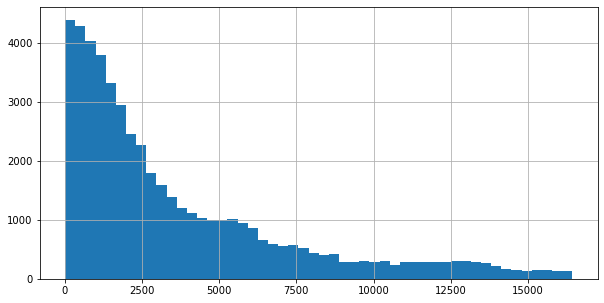

In [97]:
# посмотрим на распределение
df.Ranking.hist(bins=50,figsize=[10,5])

City
Amsterdam     AxesSubplot(0.125,0.125;0.775x0.755)
Athens        AxesSubplot(0.125,0.125;0.775x0.755)
Barcelona     AxesSubplot(0.125,0.125;0.775x0.755)
Berlin        AxesSubplot(0.125,0.125;0.775x0.755)
Bratislava    AxesSubplot(0.125,0.125;0.775x0.755)
Brussels      AxesSubplot(0.125,0.125;0.775x0.755)
Budapest      AxesSubplot(0.125,0.125;0.775x0.755)
Copenhagen    AxesSubplot(0.125,0.125;0.775x0.755)
Dublin        AxesSubplot(0.125,0.125;0.775x0.755)
Edinburgh     AxesSubplot(0.125,0.125;0.775x0.755)
Geneva        AxesSubplot(0.125,0.125;0.775x0.755)
Hamburg       AxesSubplot(0.125,0.125;0.775x0.755)
Helsinki      AxesSubplot(0.125,0.125;0.775x0.755)
Krakow        AxesSubplot(0.125,0.125;0.775x0.755)
Lisbon        AxesSubplot(0.125,0.125;0.775x0.755)
Ljubljana     AxesSubplot(0.125,0.125;0.775x0.755)
London        AxesSubplot(0.125,0.125;0.775x0.755)
Luxembourg    AxesSubplot(0.125,0.125;0.775x0.755)
Lyon          AxesSubplot(0.125,0.125;0.775x0.755)
Madrid        AxesSubplot(

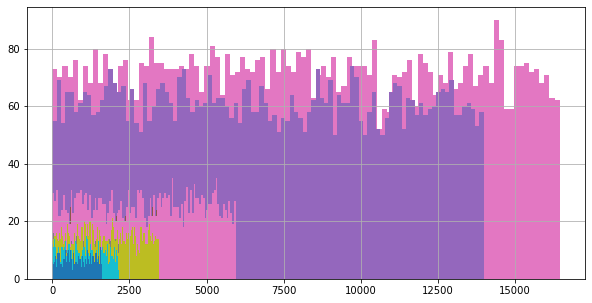

In [98]:
# распределением по городам
df.groupby(['City'])['Ranking'].hist(bins=100,figsize=[10,5])

In [99]:
df.groupby(['City'])['Ranking'].agg(['max','min','mean','std'])

,max,min,mean,std
City,,,,
Amsterdam,3254.0,1.0,1591.589650,939.209664
Athens,1787.0,3.0,880.213918,496.941674
Barcelona,7796.0,5.0,3879.422680,2264.719813
Berlin,6372.0,2.0,3255.417745,1816.592006
Bratislava,889.0,3.0,462.428947,254.272873
Brussels,3006.0,3.0,1541.901826,866.585639
Budapest,2440.0,1.0,1219.061704,703.457090
Copenhagen,1964.0,3.0,982.147741,569.147493
Dublin,1960.0,4.0,972.127990,553.079742


Чем больше представлено ресторанов, тем, соответвенно, выше может быть ранг ресторана в городе.<br>
Что бы привести данные к одному масштабу, можем разделить ранг ресторана, на кол-во заведений в датасете.<br>

In [100]:
df['Ranking scaled'] = df['Ranking']/df['Restaurants by city']

,max,min,mean,median,std
City,,,,,
Amsterdam,2.371720,0.000729,1.160051,1.153426,0.684555
Athens,2.302835,0.003866,1.134296,1.123067,0.640389
Barcelona,2.296318,0.001473,1.142687,1.137261,0.667075
Berlin,2.355638,0.000739,1.203482,1.213309,0.671568
Bratislava,2.339474,0.007895,1.216918,1.259211,0.669139
Brussels,2.287671,0.002283,1.173441,1.191781,0.659502
Budapest,2.389814,0.000979,1.193988,1.174339,0.688988
Copenhagen,2.398046,0.003663,1.199204,1.205128,0.694930
Dublin,2.344498,0.004785,1.162833,1.174043,0.661579


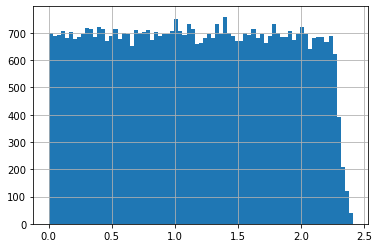

In [101]:
# и ещё раз глянем распределение
df['Ranking scaled'].hist(bins=75)
df.groupby(['City'])['Ranking scaled'].agg(['max','min','mean','median','std'])

Распределение выглядит более натурально

# One-Hot Encoding

In [102]:
df.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,ID short,Restaurant name,Not unique Rid,Restaurants same Rid,Rid short,NoR NAN,Cuisine NAN,Cuisine variety,Reviews NAN,Reviews dates,Reviews gap,Reviews sentiment,Reviews sentiment mean,Review1 sentiment,Review2 sentiment,Review1 len,Review2 len,Price NAN,Country,GDP,Country pop,City pop,City density,isCapital,City income,Michelin-starred,3Stars,2Stars,1Star,AllStars,TA DB Restaurants by city,Restaurants by city,Citizens for restaurant,Ranking scaled
43227,id_2945,Vienna,[],2947.0,2.0,2.0,[],/Restaurant_Review-g190454-d12557765-Reviews-N...,d12557765,1,3.5,12557765,Nordsee,1,4,2945,0,1,0,1,[],0,[0.0],0.000000,0.000000,0.0,0,0,0,Austria,0.4451,8.859,1.897,4.556,1,3.0,"[1, 4, 7, 12]",1,4,7,12,4151,1443,1314.622315,2.042273
33744,id_1920,Barcelona,"[Mediterranean, Spanish, Vegetarian Friendly]",1921.0,2.0,20.0,[Quality food for tapas in a very nice ambi......,/Restaurant_Review-g187497-d12481033-Reviews-V...,d12481033,1,4.5,12481033,Vivelo,1,5,1920,0,0,3,0,"[2017-07-25 00:00:00, 2017-07-13 00:00:00]",12,"[0.78, 0.7]",0.740000,0.780000,0.7,9,4,0,Spain,1.3930,46.940,1.620,15.991,0,1.9,"[2, 6, 14, 22]",2,6,14,22,9601,3395,477.172312,0.565832
816,id_816,London,"[Indian, Asian, Vegetarian Friendly]",14882.0,2.0,163.0,"[Ok Indian in Earls Court, Ok for the price]",/Restaurant_Review-g186338-d1948863-Reviews-Ne...,d1948863,0,0.0,1948863,New Asia,1,13,816,0,0,3,0,"[2017-11-03 00:00:00, 2017-09-21 00:00:00]",43,"[0.5, 0.5]",0.500000,0.500000,0.5,5,4,0,GB,2.8290,66.650,8.982,5.701,1,2.5,"[5, 8, 53, 66]",5,8,53,66,20078,7193,1248.714028,2.068956
18067,id_382,Hamburg,"[Fast Food, Vegetarian Friendly]",383.0,1.0,54.0,"[Spontaneous dinner, Lecker!!]",/Restaurant_Review-g187331-d1340190-Reviews-Ku...,d1340190,1,4.5,1340190,Kumpir,1,15,382,0,0,2,0,"[2016-11-01 00:00:00, 2016-09-06 00:00:00]",56,"[0.6, 0.0]",0.300000,0.600000,0.0,2,1,0,Germany,3.8610,83.020,1.841,2.464,0,3.8,"[1, 2, 6, 9]",1,2,6,9,3265,1186,1552.276560,0.322934
2048,id_2048,Vienna,"[Italian, Pizza]",2036.0,2.0,57.0,"[Fantastic!!! Great pasta, salad and Pizza...,...",/Restaurant_Review-g190454-d1759840-Reviews-Ca...,d1759840,0,0.0,1759840,CapaTosta,1,4,2048,0,0,2,0,"[2017-03-14 00:00:00, 2015-08-06 00:00:00]",586,"[0.790625, 0.8]",0.795313,0.790625,0.8,6,2,0,Austria,0.4451,8.859,1.897,4.556,1,3.0,"[1, 4, 7, 12]",1,4,7,12,4151,1443,1314.622315,1.410949


In [103]:
# One-Hot Encoding для переменных City Country
df = pd.get_dummies(df, columns=['City','Country'], dummy_na=True)

In [104]:
# One-Hot Encoding для Cuisine Style
cuisine_style_dummies = pd.get_dummies(df['Cuisine Style'].explode()).sum(level=0)
df = pd.concat([df, cuisine_style_dummies], axis=1)

# **EDA** 

In [105]:
# глянем таблицу корреляций датасета без dummy varaiables, sample и целевой переменной
df_corr =  df.drop(columns=['Rating','Not unique Rid','Price NAN','City_Amsterdam','City_Athens', 'City_Barcelona', 'City_Berlin', 'City_Bratislava', 'City_Brussels', 'City_Budapest',
 'City_Copenhagen', 'City_Dublin', 'City_Edinburgh', 'City_Geneva', 'City_Hamburg', 'City_Helsinki', 'City_Krakow', 'City_Lisbon', 'City_Ljubljana',
 'City_London', 'City_Luxembourg', 'City_Lyon', 'City_Madrid', 'City_Milan', 'City_Munich', 'City_Oporto', 'City_Oslo', 'City_Paris', 'City_Prague',
 'City_Rome', 'City_Stockholm', 'City_Vienna', 'City_Warsaw', 'City_Zurich', 'City_nan', 'Country_Austria', 'Country_Belgium', 'Country_Czechia',
 'Country_Denmark', 'Country_Finland', 'Country_France', 'Country_GB', 'Country_Germany', 'Country_Greece', 'Country_Hungary', 'Country_Ireland',
 'Country_Italy', 'Country_Luxembourg', 'Country_Netherlands', 'Country_Norway', 'Country_Poland', 'Country_Portugal', 'Country_Slovakia', 'Country_Slovenia', 'Country_Spain',
 'Country_Sweden', 'Country_Switzerland', 'Country_nan', 'Afghani', 'African', 'Albanian', 'American', 'Arabic', 'Argentinean', 'Armenian',
 'Asian', 'Australian', 'Austrian', 'Azerbaijani', 'Balti', 'Bangladeshi', 'Bar', 'Barbecue', 'Belgian', 'Brazilian', 'Brew Pub', 'British',
 'Burmese','Cafe', 'Cambodian', 'Canadian', 'Caribbean', 'Caucasian', 'Central American', 'Central Asian', 'Central European', 'Chilean',
 'Chinese', 'Colombian', 'Contemporary', 'Croatian', 'Cuban', 'Czech', 'Danish', 'Delicatessen', 'Diner', 'Dutch', 'Eastern European', 'Ecuadorean',
 'Egyptian', 'Ethiopian', 'European', 'Fast Food', 'Filipino', 'French', 'Fujian', 'Fusion', 'Gastropub', 'Georgian', 'German', 'Gluten Free Options',
 'Greek', 'Grill', 'Halal', 'Hawaiian', 'Healthy', 'Hungarian', 'Indian', 'Indonesian', 'International', 'Irish', 'Israeli', 'Italian', 'Jamaican',
 'Japanese', 'Korean', 'Kosher', 'Latin', 'Latvian', 'Lebanese', 'Malaysian', 'Mediterranean', 'Mexican', 'Middle Eastern', 'Minority Chinese', 'Mongolian',
 'Moroccan', 'Native American', 'Nepali', 'New Zealand', 'Norwegian', 'Pakistani', 'Persian', 'Peruvian', 'Pizza', 'Polish', 'Polynesian', 'Portuguese',
 'Pub', 'Romanian', 'Russian', 'Salvadoran', 'Scandinavian', 'Scottish', 'Seafood', 'Singaporean', 'Slovenian', 'Soups', 'South American', 'Southwestern',
 'Spanish', 'Sri Lankan', 'Steakhouse', 'Street Food', 'Sushi', 'Swedish', 'Swiss', 'Taiwanese', 'Thai', 'Tibetan', 'Tunisian', 'Turkish', 'Ukrainian',
 'Uzbek', 'Vegan Options', 'Vegetarian Friendly', 'Venezuelan', 'Vietnamese', 'Welsh', 'Wine Bar', 'Xinjiang', 'Yunnan'])

In [106]:
df_corr = df_corr.query('sample == 1')
df_corr = df_corr.drop(columns='sample')

<AxesSubplot:>

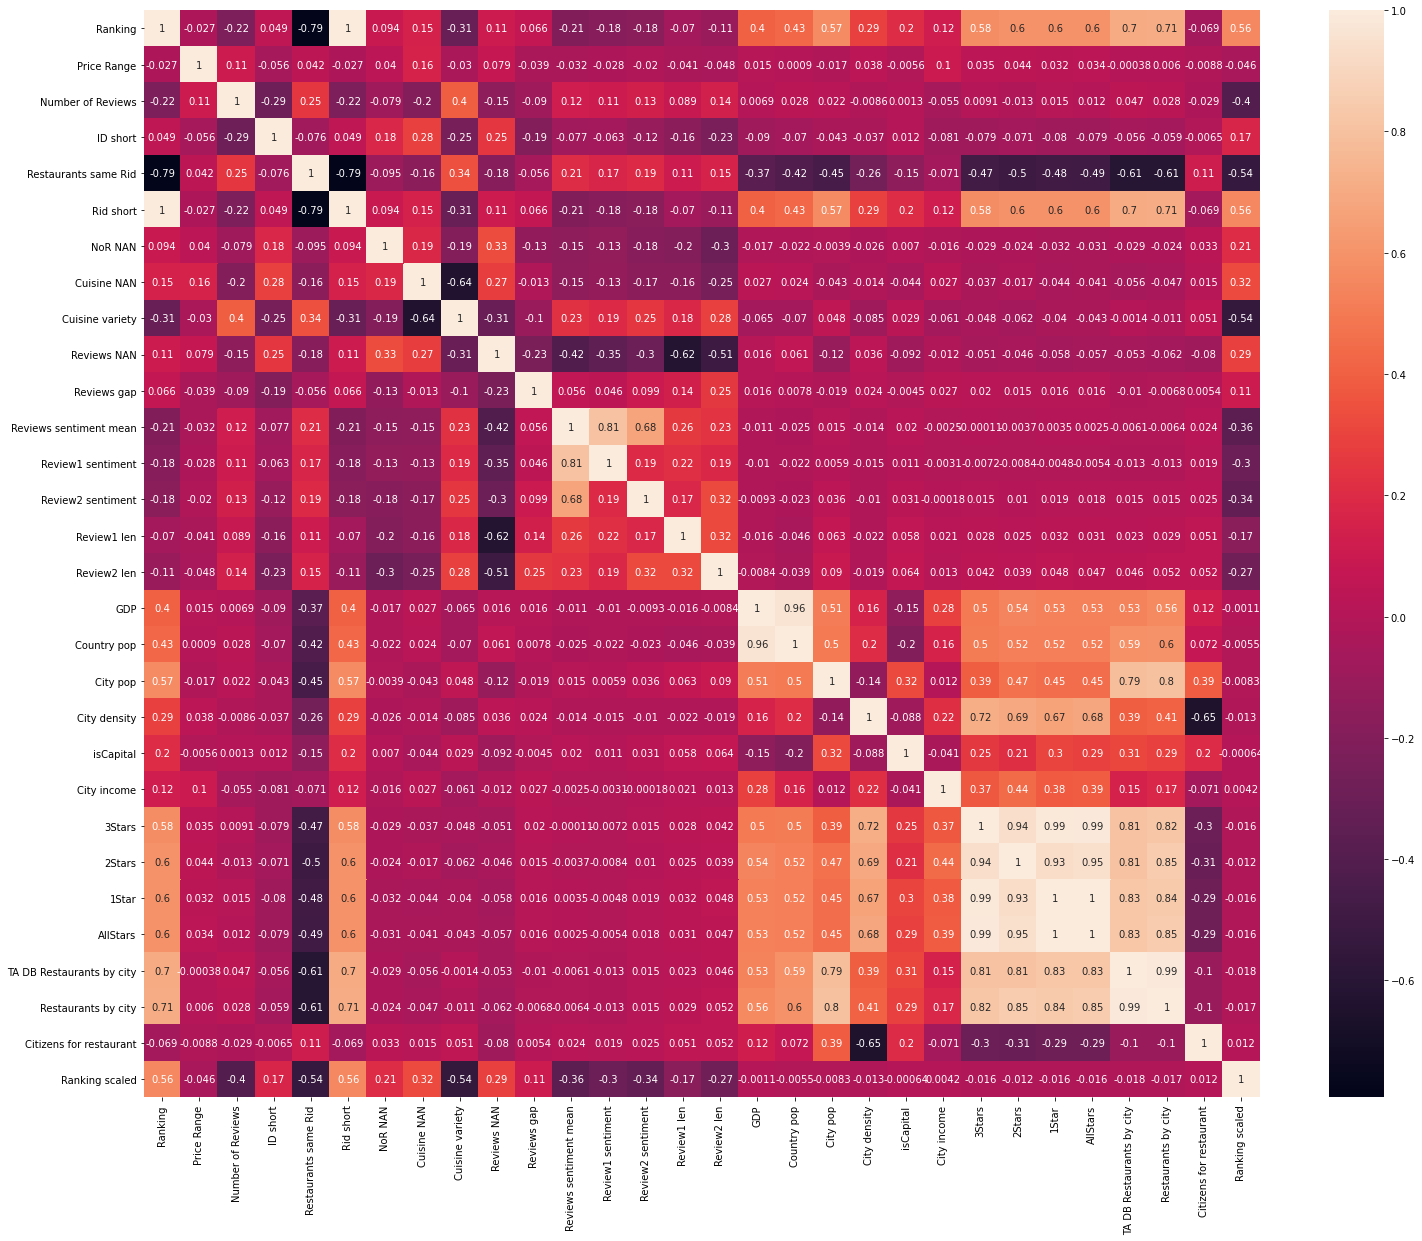

In [107]:
plt.figure(figsize=(25,20))
sns.heatmap(data=df_corr.corr(method='pearson'),annot=True)

Много коррелирующих параметров. Сравним корреляции с целевой переменной, включая dummy переменные

<AxesSubplot:>

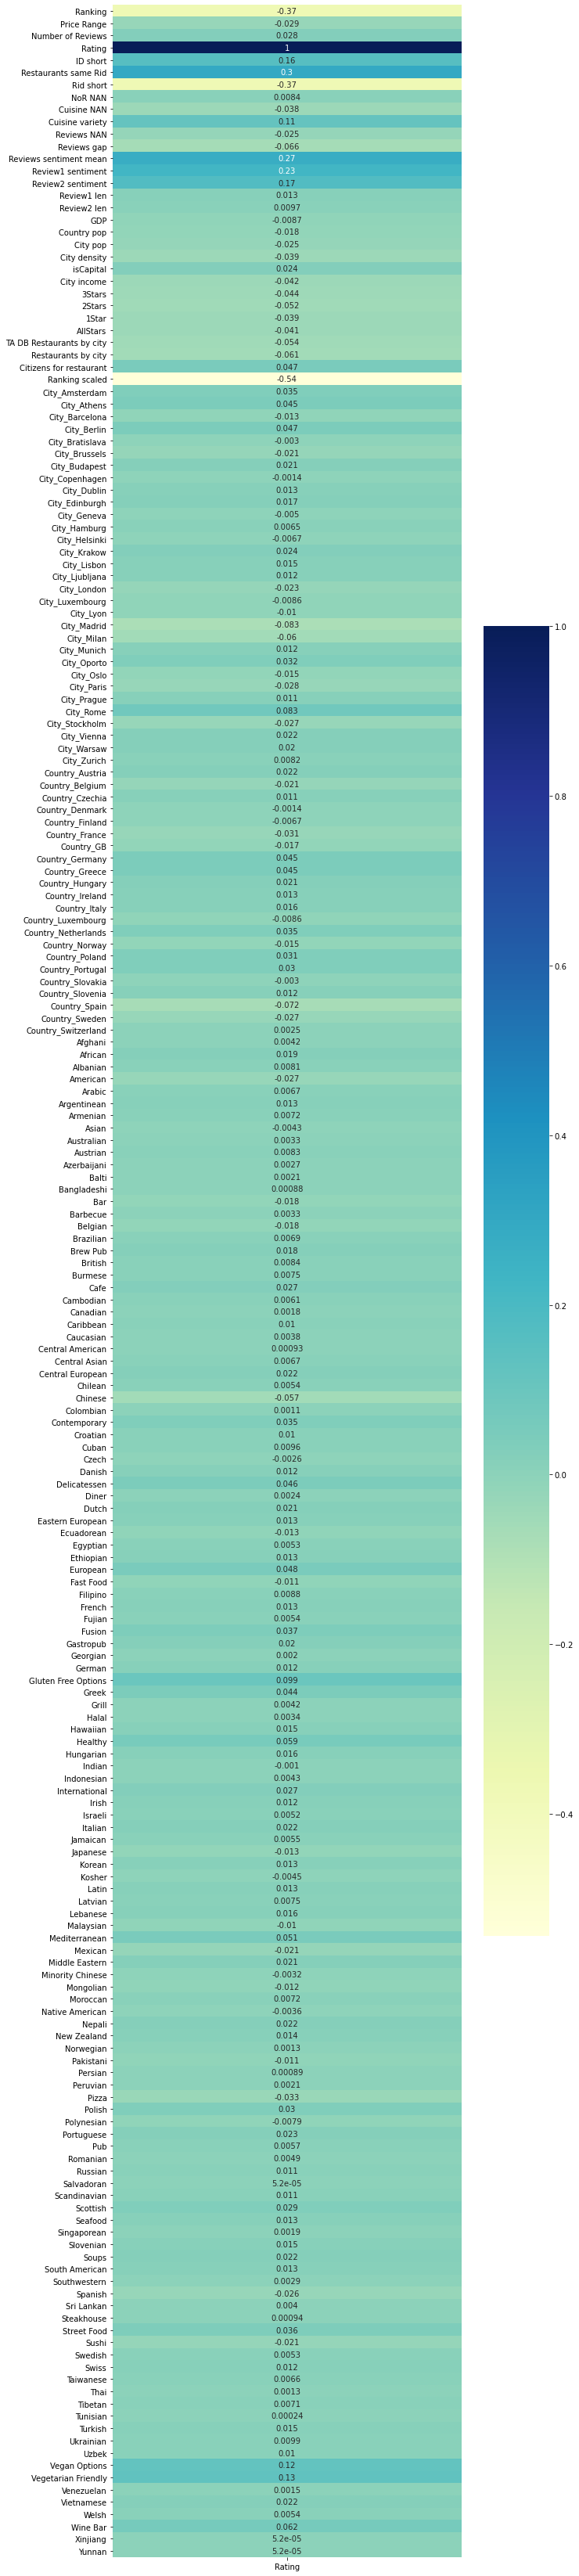

In [108]:
plt.rcParams['figure.figsize'] = (10,60)
sns.heatmap(df.query('sample == 1').corr()['Rating'].dropna().to_frame(),cmap="YlGnBu",annot=True)

Можно заметить обратную корреляцию со всему параметрами, связанными с Рангом, но особо выделяется масштабированный Ранг (Scaled Ranking). Так же наблюдается прямая связь сентимента и Рейтинга.
Из кухонь выделяются только 2: Vegan Options и Vegetarian friendly.<br>
Можно пробовать улучшить данные, но я уже не успеваю, так как сегодня отсроченный Дедлайн! Так что перейдём к обучению модели 

In [109]:
# Оставляем только числовые данные
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis = 1, inplace=True)

In [110]:
# Теперь выделим тестовую часть
train_data = df.query('sample == 1').drop(['sample'], axis=1)
test_data = df.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [111]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [112]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 212), (40000, 212), (40000, 211), (32000, 211), (8000, 211))

# Model 

In [113]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [114]:
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [115]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Заметим, что рейтинг имеет шаг 0.5. Модель предсказывает рейтинг без учёта этой детали.<br>Если вручную округлить результаты предсказания, то их качество улучшится.

In [116]:
y_pred_round = np.round(y_pred * 2)/2

In [117]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAE considering round:', metrics.mean_absolute_error(y_test, y_pred_round))

MAE: 0.20060624999999999
MAE considering round: 0.1681875


<AxesSubplot:>

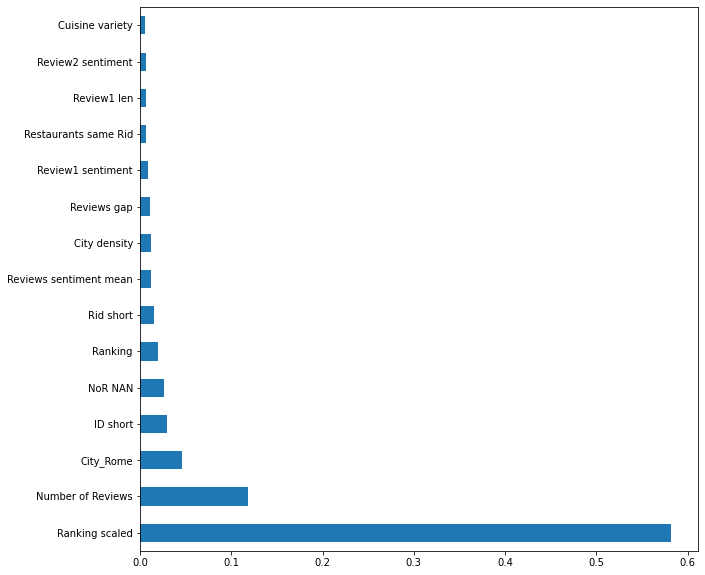

In [118]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Предсказуемо, что имея сильную линейную зависимость, Ranking Scaled является самым важным признаком

# Submission

In [119]:
test_data.shape

(10000, 212)

In [120]:
test_data = test_data.drop(['Rating'], axis=1)

In [121]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [122]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [123]:
predict_submission_round = np.round(predict_submission * 2)/2

In [124]:
sample_submission['Rating'] = predict_submission_round
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.0
2,id_2,4.0
3,id_3,4.5
4,id_4,4.5
5,id_5,4.5
6,id_6,3.0
7,id_7,2.0
8,id_8,4.0
9,id_9,4.5
